<a href="https://colab.research.google.com/github/CarineMS/UFV/blob/main/ELT575_S2A1_Image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Importando dados

Aqui usaremos o dataset MNIST (https://en.wikipedia.org/wiki/MNIST_database), que consiste em imagens de dígitos de 0 a 9 escritos manualmente. As imagens desse dataset são na escala grayscale (possuindo um único canal), tendo dimensões 28 x 28 x 1

* Usaremos a versão disponível no tensorflow, mas nada impede que as imagens sejam carregadas de alguma pasta no próprio computador ou carregadas direto para a memória como um array multidimensional (esse último é desaconselhado devido ao volume de dados que serão manipulados durante o treinamento da rede)

In [ ]:
# carregando dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

In [ ]:
trainX.min(), trainX.max(), trainX.mean(), len(trainX)

(0, 255, 33.318421449829934, 60000)

In [ ]:
trainY.min(), trainY.max()

(0, 9)

In [ ]:
testX.min(), testX.max()

(0, 255)

In [ ]:
testY.min(), testY.max()

(0, 9)

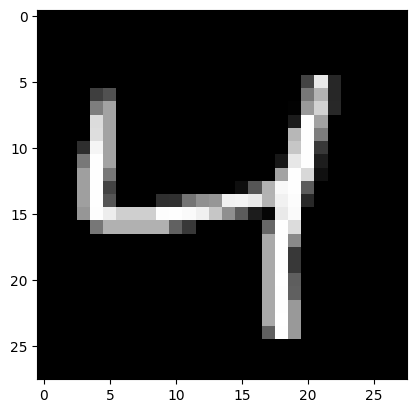

In [ ]:
plt.imshow(trainX[2], cmap='gray');

In [ ]:
# fazendo um reshape no dataset para ter um único canal
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
trainX.min(), trainX.max(), trainX.mean(), len(trainX)

(0.0, 1.0, 0.13066062, 60000)

In [ ]:
testY.min(), testY.max(), testY.mean(), len(testY)

(0.0, 1.0, 0.1, 10000)

In [ ]:
trainX.dtype

dtype('float32')

In [ ]:
trainY.shape

(60000, 10)

In [ ]:
np.unique(trainY, return_counts=True)

(array([0., 1.], dtype=float32), array([540000,  60000]))

# Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [ ]:
# definindo modelo
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

Epoch 1/10
1500/1500 [==============================] - 17s 4ms/step - loss: 0.1311 - accuracy: 0.9603 - val_loss: 0.0767 - val_accuracy: 0.9760
Epoch 2/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0423 - accuracy: 0.9863 - val_loss: 0.0769 - val_accuracy: 0.9772
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0267 - accuracy: 0.9911 - val_loss: 0.1046 - val_accuracy: 0.9706
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0806 - val_accuracy: 0.9797
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.1093 - val_accuracy: 0.9768
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0991 - val_accuracy: 0.9797
Epoch 7/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.1024 - val_accuracy

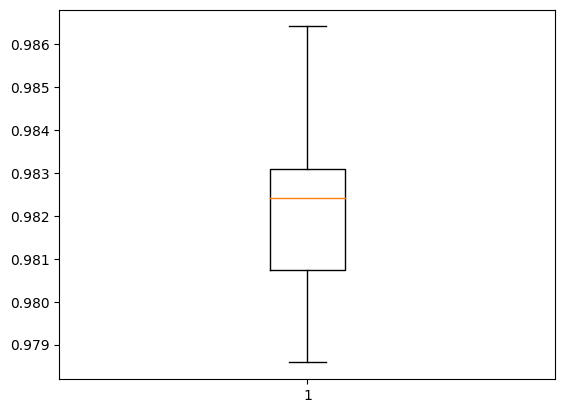

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1)

  # desempenho do modelo
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

# Testando modelo no conjunto de teste

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

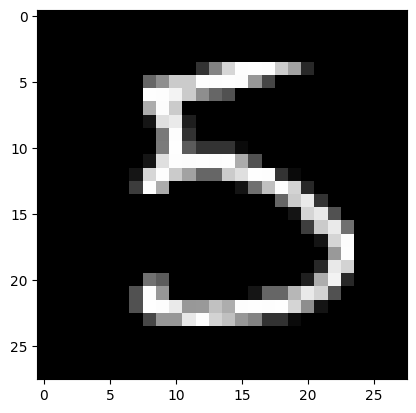

In [ ]:
plt.imshow(testX[15,:,:,0], cmap='gray');

Usaremos o último modelo treinado na validação cruzada k-fold para classificar qual número temos na imagem (podemos também salvar cada um dos modelos intermediários e usar o que apresentar maior performance ou fazer um comitê de votação com os 5 modelos disponíveis)

* temos que fazer uma expansão de dimensão para que nossa imagem tenha um formato 1 x 28 x 28 x 1. Isso é necessário pois treinamos nosso modelo usando mini conjuntos de imagens (como nosso batch size era de 32, o formato passado para o modelo a cada passo de treinamento era 32 x 28 x 28 x 1)

In [ ]:
np.argmax(model.predict(np.expand_dims(testX[15], axis=0)))

1/1 [==============================] - 0s 161ms/step


5